Import necessary libraries
-----------------------

In [1]:
import numpy as np
from scipy import ndimage
from time import time
from sklearn import datasets, manifold
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GMM
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

/Users/Anirban/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


K-means clustering
==================
Example adapted from [here](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html).

Load dataset
-----------

In [2]:
iris = datasets.load_iris()
X,y = iris.data[:,:2], iris.target

Define and train model
----------------------

In [6]:
num_clusters = 8
model = KMeans(n_clusters=num_clusters)
model.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Extract the labels and the cluster centers
-------------------

In [7]:
labels = model.labels_
cluster_centers = model.cluster_centers_
print cluster_centers

[[ 7.475       3.125     ]
 [ 4.70952381  3.15238095]
 [ 6.22307692  2.7       ]
 [ 5.52857143  4.04285714]
 [ 5.65714286  2.74285714]
 [ 4.9         2.33333333]
 [ 6.6         3.13793103]
 [ 5.15238095  3.52857143]]


Plot the clusters
---

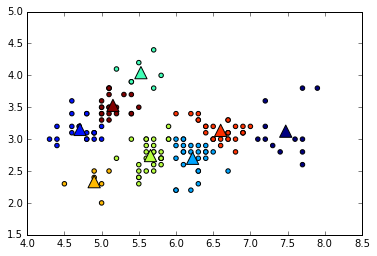

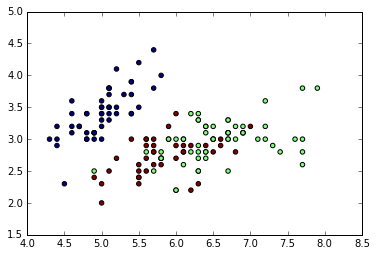

In [8]:
plt.scatter(X[:,0], X[:,1],c=labels.astype(np.float))
plt.hold(True)
plt.scatter(cluster_centers[:,0], cluster_centers[:,1], c = np.arange(num_clusters), marker = '^', s = 150)
plt.show()
plt.scatter(X[:,0], X[:,1],c=np.choose(y,[0,2,1]).astype(np.float))
plt.show()

Gaussian Mixture Model
======================
Example taken from [here](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_classifier.html#example-mixture-plot-gmm-classifier-py).

Define a visualization function
---

In [9]:
def make_ellipses(gmm, ax):
    """
    Visualize the gaussians in a GMM as ellipses
    """
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

Load dataset and make training and test splits
---

In [10]:
iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(iris.target, n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

Train and compare different GMMs
---

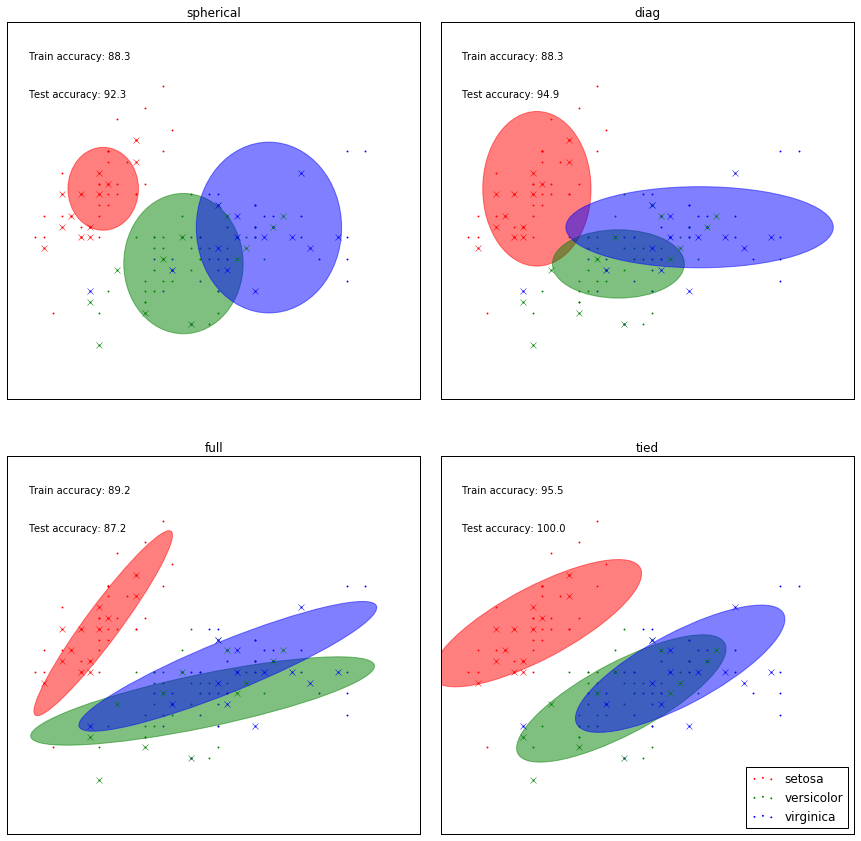

In [11]:
# Try GMMs using different types of covariances.
classifiers = dict((covar_type, GMM(n_components=n_classes,
                    covariance_type=covar_type, init_params='wc', n_iter=20))
                   for covar_type in ['spherical', 'diag', 'tied', 'full'])

n_classifiers = len(classifiers)

plt.figure(figsize=(2*3 * n_classifiers / 2, 2*6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, classifier) in enumerate(classifiers.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    classifier.means_ = np.array([X_train[y_train == i].mean(axis=0)
                                  for i in xrange(n_classes)])

    # Train the other parameters using the EM algorithm.
    classifier.fit(X_train)

    h = plt.subplot(2, n_classifiers / 2, index + 1)
    make_ellipses(classifier, h)

    for n, color in enumerate('rgb'):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], 0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate('rgb'):
        data = X_test[y_test == n]
        plt.plot(data[:, 0], data[:, 1], 'x', color=color)

    y_train_pred = classifier.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = classifier.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(loc='lower right', prop=dict(size=12))


plt.show()

Hierarchical Agglomerative Clustering
=====================================
Example taken from [here](http://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html#example-cluster-plot-digits-linkage-py).

Load and pre-process dataset
---

In [12]:
digits = datasets.load_digits(n_class=10)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

np.random.seed(0)

def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: ndimage.shift(x.reshape((8, 8)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y


X, y = nudge_images(X, y)

Visualize the clustering
---

In [13]:
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(2*6, 2*4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

Create a 2D embedding of the digits dataset
---

In [14]:
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

Computing embedding
Done.


Train and visualize the clusters
---
* __Ward__ minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
* __Maximum or complete linkage__ minimizes the maximum distance between observations of pairs of clusters.
* __Average linkage__ minimizes the average of the distances between all observations of pairs of clusters.

ward : 19.58s
average : 18.85s
complete : 18.85s


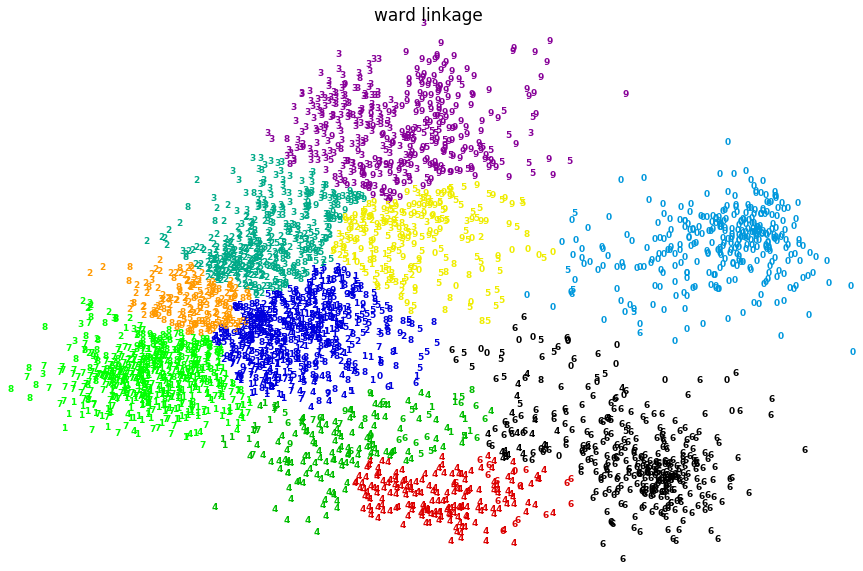

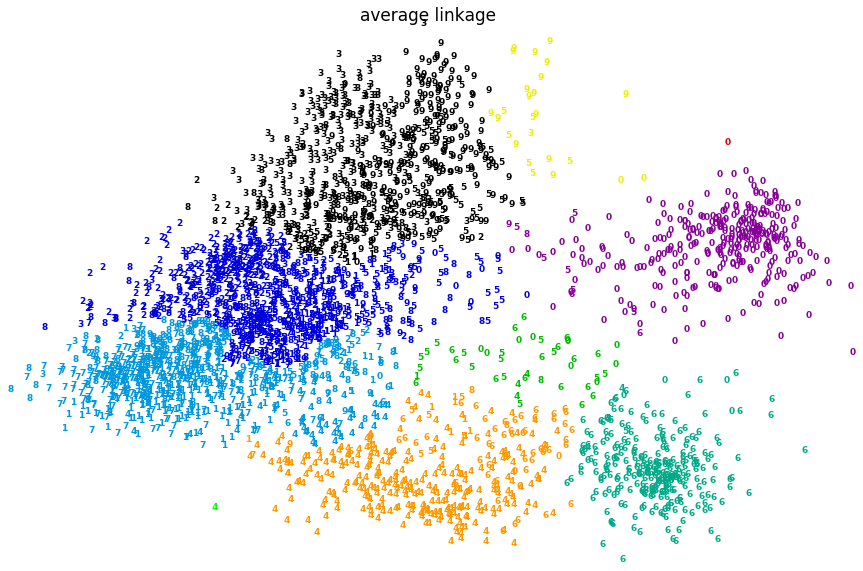

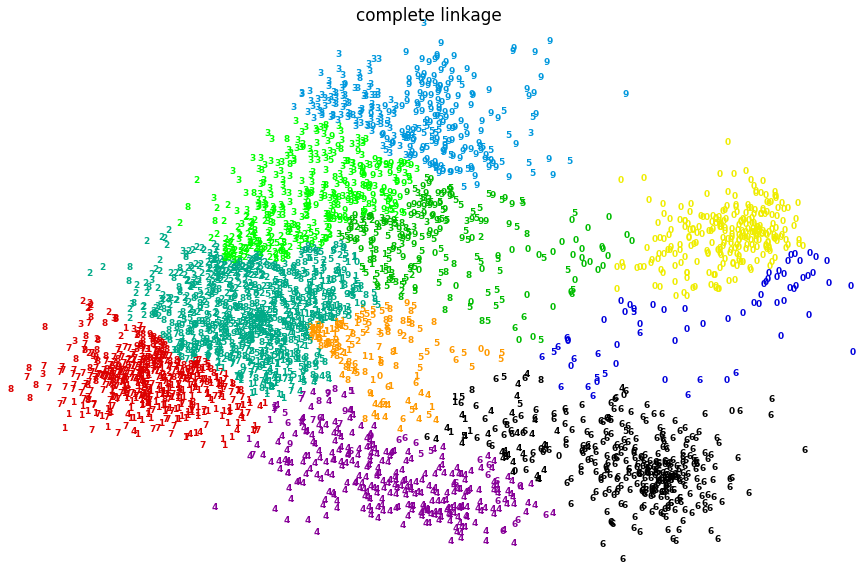

In [15]:
from sklearn.cluster import AgglomerativeClustering

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)


plt.show()